In [9]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
#from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
#from keras.layers import Dropout,Dense,TimeDistributed
#from keras.models import Sequential
#from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

C:\Users\AmanK\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [10]:
#Loading the required Audio DataSet with length of 12798 Audio Files 
os.listdir(path='.\Emotions_Single')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = './Emotions_Single'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '.\\Emotions_Single'

In [3]:
'''
#Use the Speech-Recognition API to get the Raw Text from Audio Files, Though Speech Recognition
#is less strong for large chunk of files , so used Error Handling , where when it is not be able to 
#produce the text of a particular Audio File it prints the statement 'error'.Just for understanding Audio
import speech_recognition as sr
r=sr.Recognizer()
for file in range(0 , len(listOfFiles) , 1):
    with sr.AudioFile(listOfFiles[file]) as source:
        audio = r.listen(source)
        try:
            text = r.recognize_google(audio)
            print(text)
        except:
            print('error')
'''

"\n#Use the Speech-Recognition API to get the Raw Text from Audio Files, Though Speech Recognition\n#is less strong for large chunk of files , so used Error Handling , where when it is not be able to \n#produce the text of a particular Audio File it prints the statement 'error'.Just for understanding Audio\nimport speech_recognition as sr\nr=sr.Recognizer()\nfor file in range(0 , len(listOfFiles) , 1):\n    with sr.AudioFile(listOfFiles[file]) as source:\n        audio = r.listen(source)\n        try:\n            text = r.recognize_google(audio)\n            print(text)\n        except:\n            print('error')\n"

In [4]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [5]:
'''
#Plotting the Basic Graphs for understanding of Audio Files :
for file in range(0 , len(listOfFiles) , 1):
    audio , sfreq = lr.load(listOfFiles[file])
    time = np.arange(0 , len(audio)) / sfreq
    
    fig ,ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
    plt.show()
    
#PLOT THE SEPCTOGRAM
for file in range(0 , len(listOfFiles) , 1):
     sample_rate , samples = wavfile.read(listOfFiles[file])
     frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) 
     plt.pcolormesh(times, frequencies, spectrogram)
     plt.imshow(spectrogram)
     plt.ylabel('Frequency [Hz]')
     plt.xlabel('Time [sec]')
     plt.show()

'''

"\n#Plotting the Basic Graphs for understanding of Audio Files :\nfor file in range(0 , len(listOfFiles) , 1):\n    audio , sfreq = lr.load(listOfFiles[file])\n    time = np.arange(0 , len(audio)) / sfreq\n    \n    fig ,ax = plt.subplots()\n    ax.plot(time , audio)\n    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')\n    plt.show()\n    \n#PLOT THE SEPCTOGRAM\nfor file in range(0 , len(listOfFiles) , 1):\n     sample_rate , samples = wavfile.read(listOfFiles[file])\n     frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate) \n     plt.pcolormesh(times, frequencies, spectrogram)\n     plt.imshow(spectrogram)\n     plt.ylabel('Frequency [Hz]')\n     plt.xlabel('Time [sec]')\n     plt.show()\n\n"

In [6]:
'''
#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.
#They are the Plotting Functions to be called later. 
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)
'''

"\n#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.\n#They are the Plotting Functions to be called later. \ndef plot_signals(signals):\n    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))\n    fig.suptitle('Time Series' , size=16)\n    i=0\n    for x in range(2):\n        for y in range(5):\n            axes[x,y].set_title(list(signals.keys())[i])\n            axes[x,y].plot(list(signals.values())[i])\n            axes[x,y].get_xaxis().set_visible(False)\n            axes[x,y].get_yaxis().set_visible(False)\n            i +=1\n\ndef plot_fft(fft):\n    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))\n    fig.suptitle('Fourier Transform' , size=16)\n    i=0\n    for x in range(2):\n        for y in range(5):\n            data = list(fft.values())[i]\n            Y,freq = data[0] , data[1]\n            axes[x,y].set_title(list(fft.keys())[i])\n            axes[x,y].plo

In [7]:
'''
# Here The Data Set is loaded and plots are Visualised by Calling the Plotting Functions . 
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
for file in range(0 , len(listOfFiles) , 1):
    rate, data = wav.read(listOfFiles[file])
    fft_out = fft(data)
    %matplotlib inline
    plt.plot(data, np.abs(fft_out))
    plt.show()
    
signals={}
fft={}
fbank={}
mfccs={}
# load data
for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wavfile.read(listOfFiles[file])
     signal,rate =librosa.load(listOfFiles[file] , sr=44100)
     mask = envelope(signal , rate , 0.0005)
     signals[file] = signal
     fft[file] = calc_fft(signal , rate)
    
     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
     fbank[file] = bank
     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
     mfccs[file]=mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()
'''

'\n# Here The Data Set is loaded and plots are Visualised by Calling the Plotting Functions . \nimport matplotlib.pyplot as plt\nfrom scipy.io import wavfile as wav\nfrom scipy.fftpack import fft\nimport numpy as np\nfor file in range(0 , len(listOfFiles) , 1):\n    rate, data = wav.read(listOfFiles[file])\n    fft_out = fft(data)\n    %matplotlib inline\n    plt.plot(data, np.abs(fft_out))\n    plt.show()\n    \nsignals={}\nfft={}\nfbank={}\nmfccs={}\n# load data\nfor file in range(0 , len(listOfFiles) , 1):\n#     rate, data = wavfile.read(listOfFiles[file])\n     signal,rate =librosa.load(listOfFiles[file] , sr=44100)\n     mask = envelope(signal , rate , 0.0005)\n     signals[file] = signal\n     fft[file] = calc_fft(signal , rate)\n    \n     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T\n     fbank[file] = bank\n     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T\n     mfccs[file]=mel\n\nplot_signals(signals)\nplt.show()\n\nplot_fft(f

In [8]:
'''
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask
    '''

'\n#Now Cleaning Step is Performed where:\n#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER\n#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE \ndef envelope(y , rate, threshold):\n    mask=[]\n    y=pd.Series(y).apply(np.abs)\n    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()\n    for mean in y_mean:\n        if mean>threshold:\n            mask.append(True)\n        else:\n            mask.append(False)\n    return mask\n    '

In [9]:
#The clean Audio Files are redirected to Clean Audio Folder Directory 
import glob,pickle
for file in tqdm(glob.glob(r'D:\study\Major-2\Emotions\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'D:\study\Major-2\clean_speech\\'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 12798/12798 [19:06<00:00, 14.30it/s]


In [11]:
#Feature Extraction of Audio Files Function 
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [19]:
#Emotions in the audio dataset to be classified Audio Files based on . 
emotions={
  '01':'Angry',
  '02':'Disgusted',
  '03':'Fearful',
  '04':'Happy',
  '05':'Neutral',
  '06':'Sad',
  '07':'Suprised',
}
#These are the emotions User wants to observe more :
observed_emotions=['Sad', 'Happy', 'Fearful', 'Angry']

In [20]:
#Load the data and extract features for each sound file
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'D:\study\Major-2\Emotions_Single\\**\\*.wav'):
        file_name=os.path.basename(file)
        #print(file_name)
        emotion=emotions[file_name.split("-")[1]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=8)

In [21]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
#print(*test_filename,sep="\n")

C:\Users\AmanK\AppData\Roaming\Python\Python36\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
(4897, 180) (1633, 180) (4897, 2) (1633, 2)
(4897,) (1633,)


In [22]:
#Get the shape of the training and testing datasets
# print((x_train.shape[0], x_test.shape[0]))
print((x_train[0], x_test[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-3.82807800e+02,  1.13260391e+02,  3.12429333e+01,  3.49462585e+01,
        1.16170769e+01, -2.19033718e+00,  1.70072651e+00,  8.74886066e-02,
       -3.21760035e+00, -2.34226847e+00, -1.71595931e+00, -7.57162857e+00,
       -2.60105658e+00, -5.91651583e+00, -9.88879490e+00, -5.18543959e+00,
       -2.11883187e+00, -1.65818286e+00, -2.83071995e+00, -1.05758643e+00,
        1.36854839e+00,  6.16388559e-01, -3.68528485e-01,  1.90350902e+00,
        2.91104889e+00,  5.73272228e+00,  4.62828732e+00,  4.99381447e+00,
        5.81702042e+00,  3.81598139e+00,  8.60265911e-01, -1.31086802e+00,
        5.10010481e-01,  1.96484339e+00,  1.40606248e+00,  7.42671609e-01,
       -1.71872783e+00, -9.08294559e-01,  1.54735029e+00, -5.85897207e-01,
        6.00182712e-01,  5.43412387e-01,  5.18003345e-01,  5.77356339e-01,
        5.76471329e-01,  4.60992545e-01,  4.78282034e-01,  5.22089124e-01,
        6.24788404e-01,  7.97274530e-01,  6.42120004e-01,  5.21172643e-01,
        1.55397534e-01, 

In [23]:

# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [24]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [25]:

#SAVING THE MODEL
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [26]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [27]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['Happy', 'Happy', 'Happy', ..., 'Fearful', 'Angry', 'Happy'],
      dtype='<U7')

In [28]:
#Store the Prediction probabilities into CSV file 
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')

     predictions           file_names
0          Happy    Angry-01-1591.wav
1          Happy     Happy-04-509.wav
2          Happy  Fearful-03-1107.wav
3          Happy     Happy-04-891.wav
4          Angry    Angry-01-1476.wav
5            Sad      Sad-06-1108.wav
6          Angry    Happy-04-2005.wav
7          Angry    Angry-01-2010.wav
8          Happy     Happy-04-385.wav
9            Sad      Sad-06-1552.wav
10           Sad       Sad-06-858.wav
11         Angry    Angry-01-1903.wav
12         Angry    Angry-01-1770.wav
13         Happy     Happy-04-790.wav
14         Happy     Happy-04-366.wav
15           Sad        Sad-06-20.wav
16         Angry    Angry-01-1867.wav
17           Sad      Sad-06-2078.wav
18         Happy     Happy-04-758.wav
19         Angry    Happy-04-1363.wav
20           Sad       Sad-06-946.wav
21           Sad       Sad-06-652.wav
22       Fearful    Happy-04-1302.wav
23           Sad       Sad-06-894.wav
24           Sad    Happy-04-1281.wav
25          

In [33]:
#Importing Confusion Matrix
from sklearn.metrics import confusion_matrix
#Comparing the predictions against the actual observations in y_val
cm = confusion_matrix(y_pred, y_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#DataFlair - Print the accuracy
#print("Accuracy: {:.2f}%".format(accuracy*100))

#Printing the accuracy
print("Confusion Matrix --> Accuracy of MLPClassifier : ")
print(cm)
print("Accuracy Score --> Accuracy of MLPClassifier : ", accuracy)

Confusion Matrix --> Accuracy of MLPClassifier : 
[[199  23  35   0]
 [  8  91  11   3]
 [ 63  38 380  34]
 [ 13 121 115 499]]
Accuracy Score --> Accuracy of MLPClassifier :  0.7158603796693203


In [143]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave
import datetime

CHUNK = 1024 
FORMAT = pyaudio.paInt32 #paInt8
CHANNELS = 1 
RATE = 16000 #sample rate
RECORD_SECONDS = 3

basename = "live_audio"
suffix = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
extent = ".wav"
filename1 = "_".join([basename, suffix,extent])

WAVE_OUTPUT_FILENAME = filename1
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


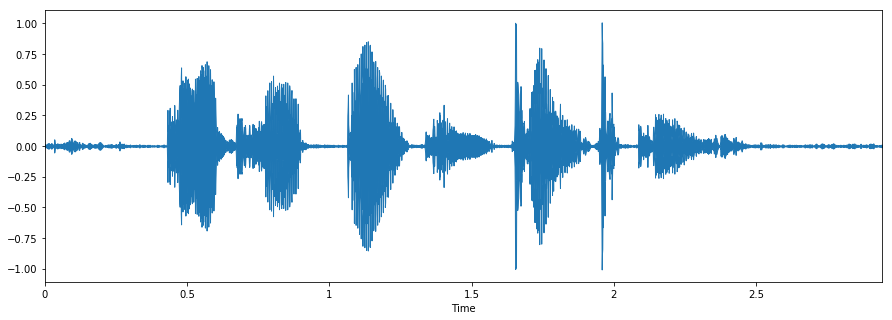

In [144]:
#The file 'output10.wav' in the next cell is the file that was recorded live using the code :
data, sampling_rate = librosa.load(filename1)
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [79]:
## Appying extract_feature function on random file and then loading model to predict the result 
import os, random
import librosa

#file2 = 'D:/study/Major-2/Emotions_Single/Happy_s/' + random.choice(os.listdir("D:/study/Major-2/Emotions_Single/Happy_s//"))
file2 = '.\Angry-01-48.wav'
#file1 = filename1

# data , sr = librosa.load(file)
# data = np.array(data)
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


In [80]:
from playsound import playsound

playsound(file2)

In [81]:
# Load the Model back from file
import pickle

with open('D:\study\Major-2\Classifier\Emotion_Voice_Detection_Model.pkl', 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

#Emotion_Voice_Detection_Model

ans =[]
new_feature = extract_feature(file2, mfcc=True, chroma=True, mel=True)
ans.append(new_feature)
ans = np.array(ans)
# data.shape

Emotion_Voice_Detection_Model.predict([ans][0])

array(['Sad'], dtype='<U7')

In [5]:
import os

f = os.getcwd()
print(f)
fn = 'Happy-04-29.wav'
f1 = os.path.join(f,fn)
print(f1)

d:\study\Major-2\Classifier
d:\study\Major-2\Classifier\Happy-04-29.wav


In [7]:
fn1 = os.path.join(os.getcwd(), fn)
print(fn1)

d:\study\Major-2\Classifier\Happy-04-29.wav
